Pistes à explorer: Remplacer output True par sections, e.g. <0, >0, >1, >5, >10

Preprocessing for classifier

In [1]:
import utils.helper_functions as hf
import pandas as pd

db_file_path = './db/ohlcv_ntickers_1254_2000-08-01_to_2023-12-23.pkl'

start_date = '2013-01-01'
target_net_profit = 0.05 #0.01 for 1%
n_future_days = 20
fee = 0.002
fee_factor = (1 - fee) / (1 + fee)

In [2]:
df = pd.read_pickle(db_file_path)
df = df[['Open']]
df = hf.remove_top_column_name(df)
df = hf.get_rows_after_date(df, start_date)

df.tail(5)

,1CALL.MI,2020.OL,5PG.OL,A2A.MI,A3M.MC,AAK.ST,AALB.AS,AB.PA,ABB.ST,ABCA.PA,...,XXL.OL,YAR.OL,YEXR.MC,YIPS.MC,YIV.MI,ZAL.OL,ZAP.OL,ZEAL.CO,ZENA.OL,ZV.MI
Date,,,,,,,,,,,,,,,,,,,,,
2023-07-24 00:00:00,NaN,97.000000,2.080,1.6820,3.560,201.800003,38.959999,3.980,418.899994,5.86,...,1.750,402.700012,0.65,1.3,0.0220,42.0,29.320000,238.000000,0.0588,15.36
2023-07-25 00:00:00,NaN,98.750000,2.090,1.7095,3.600,201.399994,39.450001,4.190,420.399994,5.95,...,1.710,406.700012,0.65,1.3,0.0216,42.0,29.299999,231.800003,0.0620,15.36
2023-07-26 00:00:00,NaN,99.699997,2.085,1.6995,3.610,204.600006,39.490002,4.040,421.899994,5.92,...,1.710,411.399994,0.65,1.3,0.0216,42.0,28.900000,225.399994,0.0620,15.68
2023-07-27 00:00:00,NaN,100.400002,2.120,1.7100,3.638,205.000000,39.619999,4.070,419.799988,5.90,...,1.710,411.799988,0.65,1.3,0.0216,42.0,29.660000,221.000000,0.0590,16.16
2023-07-28 00:00:00,NaN,101.599998,2.085,1.7100,3.650,204.399994,40.599998,3.975,425.000000,5.90,...,1.642,413.700012,0.65,1.3,0.0224,44.0,30.680000,220.199997,0.0586,16.60


In [3]:
def calculate_var(df, past_days, future_days):
    var = hf.calculate_variations(df, past_days, future_days)
    var_stacked = hf.stack(var, f'var_past_{past_days}d_future_{future_days}d')

    return var_stacked

def should_buy(df, future_days, fee):
    future_max = hf.get_future_rolling_max(df, future_days)
    var = future_max.shift(-future_days) / df
    profit = hf.apply_fee(var, fee)
    buy = profit > (1 + target_net_profit)
    buy_stacked = hf.stack(buy, f'buy_future{future_days}d')
    # buy.columns = buy.columns.str.replace('var', 'buy')

    return buy_stacked

def min_max_var(df, past_days):
    rolling_min = df.rolling(window=past_days + 1, min_periods=1).min()
    min_var = df / rolling_min
    min_var_stacked = hf.stack(min_var, f'min_var_past_{past_days}d')

    rolling_max = df.rolling(window=past_days + 1, min_periods=1).max()
    max_var = df / rolling_max
    max_var_stacked = hf.stack(max_var, f'max_var_past_{past_days}d')

    return min_var_stacked, max_var_stacked

def days_since_min_max(df, past_days):
    days_since_min = hf.get_days_since_min(df, past_days)
    days_since_min_stacked = hf.stack(days_since_min, f'days_since_min_{past_days}d')

    days_since_max = hf.get_days_since_max(df, past_days)
    days_since_max_stacked = hf.stack(days_since_max, f'days_since_max_{past_days}d')

    return days_since_min_stacked, days_since_max_stacked

def get_volatility(df, past_days):
    volatility = hf.calculate_volatility(df, past_days)
    volatility_stacked = hf.stack(volatility, f'volatility_{past_days}d')

    return volatility_stacked

def classify_var(df_var, thresholds, col_name):
    df_thresholds = hf.classify_var(df_var, thresholds)

    df_thresholds_stacked = hf.stack(df_thresholds, col_name)
    df_thresholds_stacked = df_thresholds_stacked.droplevel(level=-1)

    return df_thresholds_stacked


In [4]:
var_30 = calculate_var(df, past_days=30, future_days=0)
var_10 = calculate_var(df, past_days=10, future_days=0)
var_5 = calculate_var(df, past_days=5, future_days=0)
var_2 = calculate_var(df, past_days=2, future_days=0)
var_1 = calculate_var(df, past_days=1, future_days=0)

min_var_30, max_var_30 = min_max_var(df, past_days=30)
min_var_10, max_var_10 = min_max_var(df, past_days=10)
min_var_5, max_var_5 = min_max_var(df, past_days=5)
min_var_2, max_var_2 = min_max_var(df, past_days=2)

days_since_min_30, days_since_max_30 = days_since_min_max(df, past_days=30)
days_since_min_10, days_since_max_10 = days_since_min_max(df, past_days=10)

volatility_30 = get_volatility(df, past_days=30)
volatility_10 = get_volatility(df, past_days=10)
volatility_2 = get_volatility(df, past_days=2)

buy = should_buy(df=df, future_days=n_future_days, fee=fee)
 
buy_var_1 = calculate_var(df, past_days=0, future_days=1)
buy_var_3 = calculate_var(df, past_days=0, future_days=3)
buy_var_5 = calculate_var(df, past_days=0, future_days=5)
buy_var_10 = calculate_var(df, past_days=0, future_days=10)
buy_var_20 = calculate_var(df, past_days=0, future_days=20)
buy_var_30 = calculate_var(df, past_days=0, future_days=30)
buy_var_60 = calculate_var(df, past_days=0, future_days=60)

thresholds = [1.1, 1.05, 1.01, 1]
buy_class_1 = classify_var(buy_var_1, thresholds, 'buy_class_d1')
buy_class_3 = classify_var(buy_var_3, thresholds, 'buy_class_d3')
buy_class_5 = classify_var(buy_var_5, thresholds, 'buy_class_d5')
buy_class_10 = classify_var(buy_var_10, thresholds, 'buy_class_d10')
buy_class_20 = classify_var(buy_var_20, thresholds, 'buy_class_d20')
buy_class_30 = classify_var(buy_var_30, thresholds, 'buy_class_d30')
buy_class_60 = classify_var(buy_var_60, thresholds, 'buy_class_d60')

input_output_df = pd.concat(
        [var_30, var_10, var_5, var_2, var_1,
        min_var_30, min_var_10, min_var_5, min_var_2,
        max_var_30, max_var_10, max_var_5, max_var_2,
        days_since_min_30, days_since_min_10,
        days_since_max_30, days_since_max_10,
        volatility_30, volatility_10, volatility_2,
        buy,
        # buy_var_1, buy_var_3, buy_var_5, buy_var_10, buy_var_20, buy_var_30, buy_var_60,
        buy_class_1, buy_class_3, buy_class_5, buy_class_10, buy_class_20, buy_class_30, buy_class_60],
    axis='columns')

input_output_df = input_output_df.dropna()

input_columns = [col for col in input_output_df.columns if not col.startswith('buy')]
output_columns = [col for col in input_output_df.columns if col.startswith('buy_future')]

input_df = input_output_df[input_columns]
output_df = input_output_df[output_columns]

input_output_df.tail(5)

var_past_30d_future_0d  var_past_10d_future_0d  \
Date                                                                           
2023-04-27 00:00:00 XVIVO.ST                1.269231                1.242678   
                    YEXR.MC                 1.000000                1.000000   
                    YIPS.MC                 0.983871                1.025210   
                    YIV.MI                  0.929368                0.968992   
                    ZV.MI                   0.983471                0.897629   

                              var_past_5d_future_0d  var_past_2d_future_0d  \
Date                                                                         
2023-04-27 00:00:00 XVIVO.ST               1.169291               1.043937   
                    YEXR.MC                1.000000               1.000000   
                    YIPS.MC                1.016667               1.000000   
                    YIV.MI                 0.932836               0.961538   
                    ZV.MI                  0.919426               0.978848   

                              var_past_1d_future_0d  min_var_past_30d  \
Date                                                                    
2023-04-27 00:00:00 XVIVO.ST               1.033043          1.299781   
                    YEXR.MC                1.000000          1.000000   
                    YIPS.MC                1.000000          1.025210   
                    YIV.MI                 0.984252          1.016260   
                    ZV.MI                  0.995221          1.000000   

                              min_var_past_10d  min_var_past_5d  \
Date                                                              
2023-04-27 00:00:00 XVIVO.ST          1.245283         1.180915   
                    YEXR.MC           1.000000         1.000000   
                    YIPS.MC           1.025210         1.016667   
                    YIV.MI            1.000000         1.000000   
                    ZV.MI             1.000000         1.000000   

                              min_var_past_2d  max_var_past_30d  ...  \
Date                                                             ...   
2023-04-27 00:00:00 XVIVO.ST         1.043937          1.000000  ...   
                    YEXR.MC          1.000000          1.000000  ...   
                    YIPS.MC          1.000000          0.983871  ...   
                    YIV.MI           1.000000          0.874126  ...   
                    ZV.MI            1.000000          0.882415  ...   

                              volatility_10d  volatility_2d  buy_future20d  \
Date                                                                         
2023-04-27 00:00:00 XVIVO.ST    3.247944e-02       0.015909          False   
                    YEXR.MC     2.955309e-10       0.000000          False   
                    YIPS.MC     4.025698e-03       0.000000          False   
                    YIV.MI      2.288565e-02       0.005182          False   
                    ZV.MI       1.524438e-02       0.008254          False   

                              buy_class_d1  buy_class_d3  buy_class_d5  \
Date                                                                     
2023-04-27 00:00:00 XVIVO.ST             4             2             2   
                    YEXR.MC              4             4             4   
                    YIPS.MC              4             4             4   
                    YIV.MI               4             2             4   
                    ZV.MI                3             2             2   

                              buy_class_d10  buy_class_d20  buy_class_d30  \
Date                                                                        
2023-04-27 00:00:00 XVIVO.ST              3              4              4   
                    YEXR.MC               4              4              4   
                    YIPS.MC               2              2   

In [5]:
last_column_df = hf.get_last_column(output_df)
true_percentage = (last_column_df.sum() / len(last_column_df)) * 100
print(f'True percentage: {true_percentage}%')
print(f'Size: {len(last_column_df)}')

True percentage: 26.97637302264482%
Size: 1629070


TensorFlow True (buy)/False (don't buy)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_all = StandardScaler().fit_transform(input_df)
y_all = output_df.values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, test_size=0.2, random_state=42)

model = Sequential()

model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
# model.add(BatchNormalization(input_shape=(X_train.shape[1],)))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.05))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.05))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))

2024-01-09 18:35:05.693532: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/3
40727/40727 [==============================] - 199s 5ms/step - loss: 0.5797 - accuracy: 0.7297 - val_loss: 0.5769 - val_accuracy: 0.7301
Epoch 2/3
40727/40727 [==============================] - 189s 5ms/step - loss: 0.5766 - accuracy: 0.7302 - val_loss: 0.5749 - val_accuracy: 0.7301
Epoch 3/3
40727/40727 [==============================] - 201s 5ms/step - loss: 0.5760 - accuracy: 0.7303 - val_loss: 0.5794 - val_accuracy: 0.7301


In [7]:
y_prediction_probabilities = model.predict(X_test)
y_prediction_boolean = (y_prediction_probabilities > 0.5).astype('bool')

hf.print_report(y_real=y_test, y_prediction=y_prediction_boolean)


Classification Report:
              precision    recall  f1-score   support

       False       0.73      1.00      0.84    237885
        True       0.33      0.00      0.00     87929

    accuracy                           0.73    325814
   macro avg       0.53      0.50      0.42    325814
weighted avg       0.62      0.73      0.62    325814


    True Positive (Acheté, bon choix): 1
    True Negative (Pas acheté, bon choix): 237883
    False Positive (Acheté, mauvais choix): 2
    False Negative (Pas acheté, mauvais choix): 87928
    


In [8]:
confidence_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def get_percent_btw_thresholds(arr, threshold):
    btw_thresholds = arr[(arr > threshold) & (arr < threshold + 0.1)]
    percent_btw_thresholds = (len(btw_thresholds) / len(arr)) * 100
    return percent_btw_thresholds

for threshold in confidence_thresholds:
    percent_btw_thresholds = get_percent_btw_thresholds(y_prediction_probabilities, threshold)
    print(f'Prediction confidence {threshold} to {round(threshold + 0.1, 1)}: {percent_btw_thresholds:.2f}%')


Prediction confidence 0 to 0.1: 3.36%
Prediction confidence 0.1 to 0.2: 27.02%
Prediction confidence 0.2 to 0.3: 40.78%
Prediction confidence 0.3 to 0.4: 28.79%
Prediction confidence 0.4 to 0.5: 0.04%
Prediction confidence 0.5 to 0.6: 0.00%
Prediction confidence 0.6 to 0.7: 0.00%
Prediction confidence 0.7 to 0.8: 0.00%
Prediction confidence 0.8 to 0.9: 0.00%
Prediction confidence 0.9 to 1.0: 0.00%


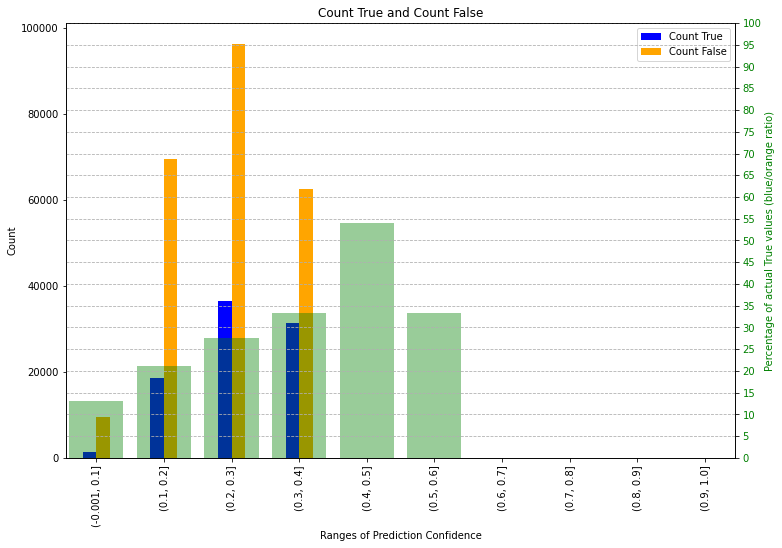

In [9]:
import matplotlib.pyplot as plt

df_predictions = pd.DataFrame(y_prediction_probabilities, columns=['predictions'])
df_results = pd.DataFrame(y_test, columns=['results'])
df_plot = pd.concat(
    [df_predictions, df_results],
    axis='columns')

# Grouping by ranges of 0.1 for numeric values and calculating percentage of True
ranges = pd.cut(df_plot['predictions'], bins=[i/10 for i in range(11)], include_lowest=True)
grouped = df_plot.groupby(ranges)['results']
percentage_true = grouped.mean() * 100  # Calculating mean as percentage
count_true = grouped.sum()
count_false = grouped.count() - count_true 

data = pd.DataFrame({'Count True': count_true, 'Count False': count_false})

fig, ax1 = plt.subplots(figsize=(12, 8))

# Creating bars for Count True and Count False
data.plot(kind='bar', width=0.4, ax=ax1, color=['blue', 'orange'])
ax1.set_ylabel('Count')
ax1.set_xlabel('Ranges of Prediction Confidence')
ax1.set_title('Count True and Count False')

ax2 = ax1.twinx()

ax2.bar(percentage_true.index.astype(str), percentage_true, color='green', alpha=0.4, label='Percentage of True')
ax2.set_ylabel('Percentage of actual True values (blue/orange ratio)', color='green')
ax2.set_xlabel('Ranges of Prediction Confidence')
ax2.grid(axis='y', linestyle='--')
ax2.yaxis.get_major_locator().set_params(nbins=20)
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(0, 100)

plt.show()

TensorFlow classes (0: >1.1, 1: >1.05, 2: >1.01, 3: >1, 4: <1) for d+5

In [10]:
input_df.head(5)

var_past_30d_future_0d  var_past_10d_future_0d  \
Date                                                                          
2013-02-13 00:00:00 A2A.MI                 1.045262                0.930159   
                    A3M.MC                 1.144304                0.961702   
                    AALB.AS                1.035523                0.985637   
                    AB.PA                  1.065441                1.047872   
                    ABCA.PA                0.984456                0.950000   

                             var_past_5d_future_0d  var_past_2d_future_0d  \
Date                                                                        
2013-02-13 00:00:00 A2A.MI                1.018466               1.032599   
                    A3M.MC                1.102439               1.029613   
                    AALB.AS               0.996973               1.014163   
                    AB.PA                 1.080636               1.089602   
                    ABCA.PA               0.991304               1.000000   

                             var_past_1d_future_0d  min_var_past_30d  \
Date                                                                   
2013-02-13 00:00:00 A2A.MI                1.004500          1.050885   
                    A3M.MC                1.031963          1.144304   
                    AALB.AS               1.026808          1.035523   
                    AB.PA                 1.111111          1.111111   
                    ABCA.PA               0.998249          1.000000   

                             min_var_past_10d  min_var_past_5d  \
Date                                                             
2013-02-13 00:00:00 A2A.MI           1.050885         1.050885   
                    A3M.MC           1.110565         1.105134   
                    AALB.AS          1.026808         1.026808   
                    AB.PA            1.111111         1.111111   
                    ABCA.PA          1.000000         1.000000   

                             min_var_past_2d  max_var_past_30d  \
Date                                                             
2013-02-13 00:00:00 A2A.MI          1.032599          0.930159   
                    A3M.MC          1.031963          0.914980   
                    AALB.AS         1.026808          0.975133   
                    AB.PA           1.111111          0.883804   
                    ABCA.PA         1.000000          0.950000   

                             max_var_past_10d  max_var_past_5d  \
Date                                                             
2013-02-13 00:00:00 A2A.MI           0.930159         1.000000   
                    A3M.MC           0.961702         1.000000   
                    AALB.AS          0.975133         0.996973   
                    AB.PA            1.000000         1.000000   
                    ABCA.PA          0.950000         0.989583   

                             max_var_past_2d  days_since_min_30d  \
Date                                                               
2013-02-13 00:00:00 A2A.MI          1.000000                 3.0   
                    A3M.MC          1.000000                30.0   
                    AALB.AS         1.000000                30.0   
                    AB.PA           1.000000                 1.0   
                    ABCA.PA         0.998249                 2.0   

                             days_since_min_10d  days_since_max_30d  \
Date                                                                  
2013-02-13 00:00:00 A2A.MI                  3.0                10.0   
                    A3M.MC                  7.0                12.0   
                    AALB.AS                 1.0                 7.0   
                    AB.PA                   1.0                25.0   
                    ABCA.PA                 2.0                22.0   

                             days_since_max_10d  volatility_30d  \

In [11]:
output_df.head(5)

buy_future20d
Date                                      
2013-02-13 00:00:00 A2A.MI           False
                    A3M.MC           False
                    AALB.AS          False
                    AB.PA            False
                    ABCA.PA          False

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_all = StandardScaler().fit_transform(input_df)
output_df = input_output_df[['buy_class_d5']]
y_all = output_df.values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, test_size=0.2, random_state=42)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

last_layers_size = len(thresholds) + 1

model = Sequential()

model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(last_layers_size, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=6, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/6
40727/40727 [==============================] - 157s 4ms/step - loss: 1.2340 - accuracy: 0.5211 - val_loss: 1.2290 - val_accuracy: 0.5223
Epoch 2/6
40727/40727 [==============================] - 167s 4ms/step - loss: 1.2211 - accuracy: 0.5224 - val_loss: 1.2240 - val_accuracy: 0.5232
Epoch 3/6
40727/40727 [==============================] - 162s 4ms/step - loss: 1.2193 - accuracy: 0.5224 - val_loss: 1.2208 - val_accuracy: 0.5232
Epoch 4/6
40727/40727 [==============================] - 127s 3ms/step - loss: 1.2187 - accuracy: 0.5224 - val_loss: 1.2675 - val_accuracy: 0.5229
Epoch 5/6
40727/40727 [==============================] - 127s 3ms/step - loss: 1.2180 - accuracy: 0.5224 - val_loss: 1.4263 - val_accuracy: 0.5232
Epoch 6/6
40727/40727 [==============================] - 146s 4ms/step - loss: 1.2179 - accuracy: 0.5224 - val_loss: 1.2946 - val_accuracy: 0.5232


In [13]:
import numpy as np

y_prediction = model.predict(X_test)
# hf.print_report(y_real=y_test, y_prediction=y_prediction)
print(y_prediction)


[[0.00817651 0.03203411 0.23174182 0.15890552 0.56914204]
 [0.08047741 0.13196357 0.21891667 0.06289877 0.50574356]
 [0.05604666 0.12687667 0.20818654 0.06592127 0.54296887]
 ...
 [0.04032521 0.11455402 0.25037992 0.07764622 0.5170947 ]
 [0.03096558 0.1056288  0.24339798 0.08356027 0.5364474 ]
 [0.00960746 0.05069892 0.2950369  0.15282676 0.49182993]]


In [14]:
df_prediction = pd.DataFrame(y_prediction, columns=['Prob_0', 'Prob_1', 'Prob_2', 'Prob_3', 'Prob_4'])
df_test = pd.DataFrame({'Real_Class': y_test})
df = pd.concat([df_prediction, df_test], axis=1)

threshold = 0.5
df['Cumulated_Probs'] = df['Prob_0'] # + df['Prob_1']
df['Predicted_True'] = (df['Cumulated_Probs'] > threshold)
df['Real_True'] = (df['Real_Class'] <= 1)

df.head(5)

,Prob_0,Prob_1,Prob_2,Prob_3,Prob_4,Real_Class,Cumulated_Probs,Predicted_True,Real_True
0,0.008177,0.032034,0.231742,0.158906,0.569142,2,0.008177,False,False
1,0.080477,0.131964,0.218917,0.062899,0.505744,2,0.080477,False,False
2,0.056047,0.126877,0.208187,0.065921,0.542969,4,0.056047,False,False
3,0.039385,0.104706,0.258433,0.088472,0.509005,4,0.039385,False,False
4,0.025278,0.093503,0.282555,0.099350,0.499315,3,0.025278,False,False


In [15]:
tp = ((df['Real_True'] == True) & (df['Predicted_True'] == True)).sum()
tn = ((df['Real_True'] == False) & (df['Predicted_True'] == False)).sum()
fp = ((df['Real_True'] == False) & (df['Predicted_True'] == True)).sum()
fn = ((df['Real_True'] == True) & (df['Predicted_True'] == False)).sum()

print(f"True Positives (TP), Correctly bought, earned money: {tp}")
print(f"True Negatives (TN), Correctly not bought: {tn}")
print(f"False Positives (FP), Incorrectly bought, may have lost money : {fp}")
print(f"False Negatives (FN), Missed buying opportunity: {fn}")

winning_rate = tp / (tp + fp)
print(f'Winning rate: {round(winning_rate * 100, 2)} %')

True Positives (TP), Correctly bought, earned money: 18
True Negatives (TN), Correctly not bought: 283569
False Positives (FP), Incorrectly bought, may have lost money : 45
False Negatives (FN), Missed buying opportunity: 42182
Winning rate: 28.57 %
